# 1. Data Processing and Cleaning of Data 

In [8]:
import pandas as pd
import requests
from io import StringIO

# Defining the headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Connection': 'keep-alive'
}

# Loading the dataset from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_National_Basketball_Association_annual_scoring_leaders'
try:
    # Fetching the page content using requests
    response = requests.get(url, headers=headers)
    response.raise_for_status() 
    
    # Pass the HTML content to pandas.read_html using StringIO
    tables = pd.read_html(StringIO(response.text))
    
    # Inspect available tables
    print(f"Number of tables found: {len(tables)}")
    
    # Select the table with annual leaders (index 1)
    df = tables[1]
    
    # Print column names to verify
    print("Available columns in the table:\n", df.columns.tolist())
    
    # Define expected columns
    expected_columns = ['Season', 'Player', 'Team', 'GP', 'Total points', 'Points per game']
    
    # Checking if the expected columns exist
    missing_cols = [col for col in expected_columns if col not in df.columns]
    if missing_cols:
        print(f"Warning: Columns {missing_cols} not found. Adjust column names based on printed columns.")
        # Mapping actual column names to expected ones
        column_mapping = {
            'Season': 'Season',
            'Player': 'Player',
            'Team': 'Team',
            'GP': 'GP',
            'Total points': 'Total points',
            'Points per game': 'Points per game'
        }
        df = df.rename(columns=column_mapping)[expected_columns].copy()
    else:
        df = df[expected_columns].copy()

    # Extracting 'Year' from Season for filtering
    df['Year'] = df['Season'].str[:4].astype(int)

    # Filtering from 1992-93 onwards (Year >= 1992)
    df = df[df['Year'] >= 1992].copy()

    # Handleing any notes in Player (e.g., remove superscripts or nationality flags)
    df['Player'] = df['Player'].str.replace(r'\[.*\]', '', regex=True).str.strip()  # Remove [a], [b], etc.
    df['Player'] = df['Player'].str.replace(r'\^', '', regex=True)  # Remove any ^ notes

    # Converting data types
    df['Games Played'] = pd.to_numeric(df['GP'], errors='coerce').astype(int)
    df['Total Points'] = pd.to_numeric(df['Total points'], errors='coerce').astype(int)
    df['Points per Game'] = pd.to_numeric(df['Points per game'], errors='coerce')

    # Droping original columns after type conversion
    df = df.drop(columns=['GP', 'Total points', 'Points per game'])

    # Checking for missing values or duplicates
    print("Missing values:\n", df.isnull().sum())
    print("Duplicates:", df.duplicated().sum())

    # Descriptive stats
    print("\nDescriptive Statistics:\n", df.describe())

    # Save to CSV for reproducibility
    df.to_csv('nba_scoring_leaders.csv', index=False)
    print("Dataset saved as 'nba_scoring_leaders.csv'")

except requests.exceptions.HTTPError as e:
    print(f"HTTP Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

Number of tables found: 7
Available columns in the table:
 ['Season', 'Player', 'Age[a]', 'Pos[b]', 'Team', 'GP', 'Field goals made', '3-point field goals made', 'Free throws made', 'Total points', 'Points per game', 'Ref']
Missing values:
 Season             0
Player             0
Team               0
Year               0
Games Played       0
Total Points       0
Points per Game    0
dtype: int64
Duplicates: 0

Descriptive Statistics:
              Year  Games Played  Total Points  Points per Game
count    33.00000     33.000000     33.000000        33.000000
mean   2008.00000     73.666667   2273.060606        30.812121
std       9.66954      7.816915    306.359872         2.202237
min    1992.00000     48.000000   1284.000000        26.800000
25%    2000.00000     68.000000   2161.000000        29.600000
50%    2008.00000     76.000000   2344.000000        30.400000
75%    2016.00000     79.000000   2431.000000        32.000000
max    2024.00000     82.000000   2832.000000        36

# 2. Exploratory Data Analysis (EDA) and Visualizations

Correlation Matrix:
                      Year  Games Played  Total Points  Points per Game
Year             1.000000     -0.215400      0.024569         0.383900
Games Played    -0.215400      1.000000      0.858970         0.201378
Total Points     0.024569      0.858970      1.000000         0.670987
Points per Game  0.383900      0.201378      0.670987         1.000000


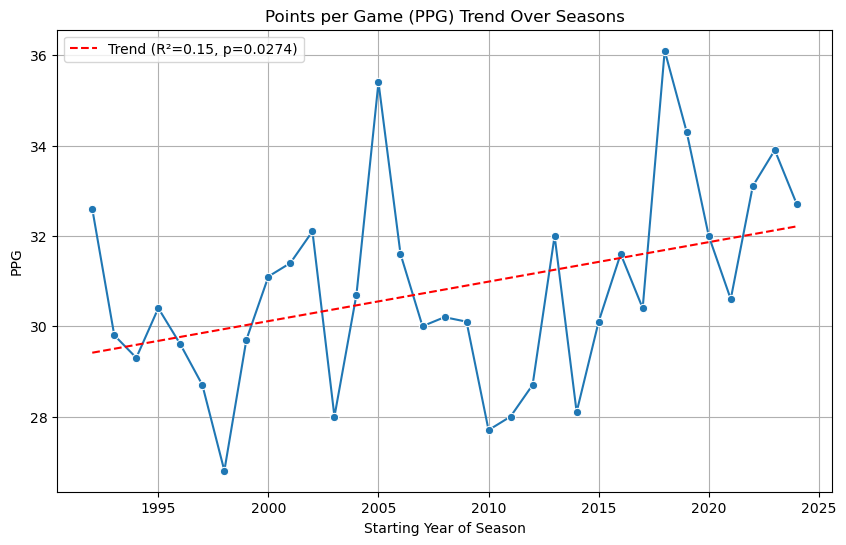

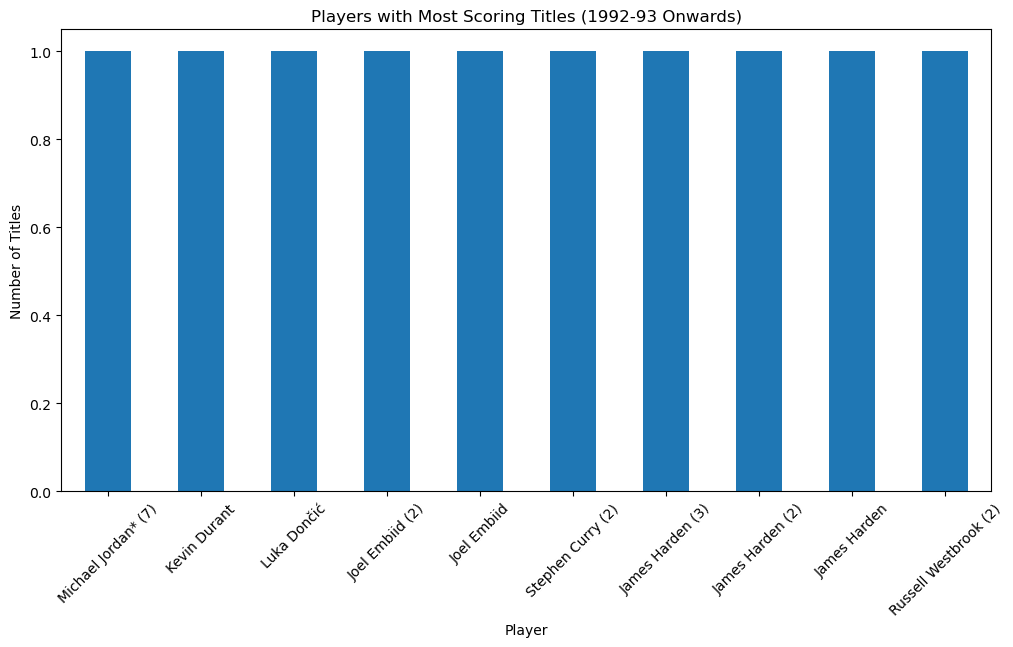

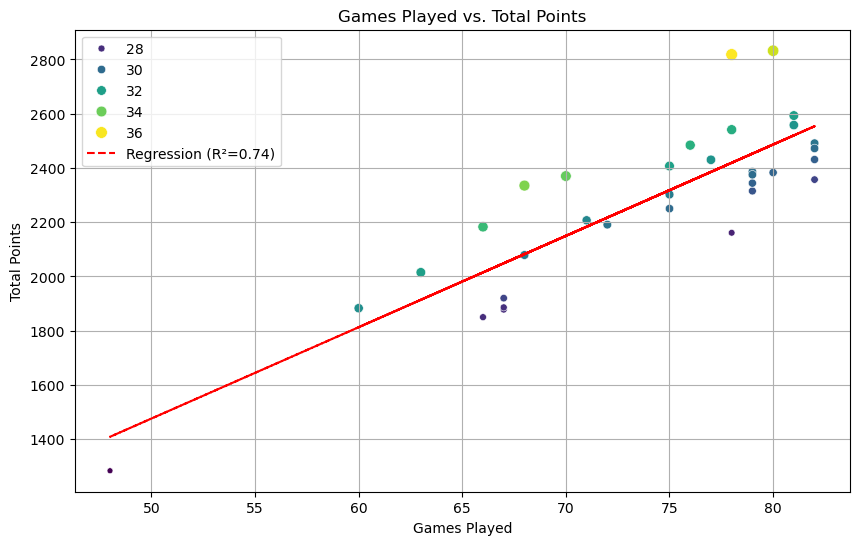

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Correlation matrix
corr = df[['Year', 'Games Played', 'Total Points', 'Points per Game']].corr()
print("Correlation Matrix:\n", corr)

# Visualization 1: Line Plot of PPG Over Years
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Points per Game', data=df, marker='o')
slope, intercept, r_value, p_value, std_err = linregress(df['Year'], df['Points per Game'])
plt.plot(df['Year'], slope * df['Year'] + intercept, 'r--', label=f'Trend (R²={r_value**2:.2f}, p={p_value:.4f})')
plt.title('Points per Game (PPG) Trend Over Seasons')
plt.xlabel('Starting Year of Season')
plt.ylabel('PPG')
plt.legend()
plt.grid(True)
plt.show()

# Visualization 2: Bar Plot of Top Players with Most Scoring Titles
player_counts = df['Player'].value_counts().head(10)  # Top 10 for clarity
plt.figure(figsize=(12, 6))
player_counts.plot(kind='bar')
plt.title('Players with Most Scoring Titles (1992-93 Onwards)')
plt.xlabel('Player')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.show()

# Visualization 3: Scatter Plot of Games Played vs. Total Points
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Games Played', y='Total Points', data=df, hue='Points per Game', palette='viridis', size='Points per Game')
slope, intercept, r_value, p_value, std_err = linregress(df['Games Played'], df['Total Points'])
plt.plot(df['Games Played'], slope * df['Games Played'] + intercept, 'r--', label=f'Regression (R²={r_value**2:.2f})')
plt.title('Games Played vs. Total Points')
plt.xlabel('Games Played')
plt.ylabel('Total Points')
plt.legend()
plt.grid(True)
plt.show()

# 3. Feature Engineering to Discover Hidden Patterns or Correlations

In [26]:
from scipy.stats import pearsonr

# New Feature: Multiple Winner (boolean: True if player has more than one title in the dataset)
player_titles = df['Player'].value_counts()
df['Multiple Winner'] = df['Player'].apply(lambda x: player_titles[x] > 1)

# Discoveries: Temporal Patterns (regression on Year vs. PPG)
slope, intercept, r_value, p_value, std_err = linregress(df['Year'], df['Points per Game'])
print(f"Temporal Trend: Slope={slope:.4f}, R-squared={r_value**2:.4f}, p-value={p_value:.4f}")

# Player and Team Correlations: Count titles per team
team_titles = df['Team'].value_counts()
print("Teams with Most Scoring Leaders:\n", team_titles.head())

# Correlation between Games Played and Year
corr_games_year, p_games_year = pearsonr(df['Year'], df['Games Played'])
print(f"Correlation Games Played vs. Year: {corr_games_year:.3f} (p={p_games_year:.3f})")

# Other Correlations
corr_total_games, _ = pearsonr(df['Games Played'], df['Total Points'])
corr_ppg_games, _ = pearsonr(df['Games Played'], df['Points per Game'])
print(f"Total Points vs. Games Played: {corr_total_games:.3f}")
print(f"PPG vs. Games Played: {corr_ppg_games:.3f}")

Temporal Trend: Slope=0.0874, R-squared=0.1474, p-value=0.0274
Teams with Most Scoring Leaders:
 Team
Oklahoma City Thunder    7
Philadelphia 76ers       6
Chicago Bulls            4
Orlando Magic            3
Los Angeles Lakers       3
Name: count, dtype: int64
Correlation Games Played vs. Year: -0.215 (p=0.229)
Total Points vs. Games Played: 0.859
PPG vs. Games Played: 0.201


# 4. Summary with 3 Actionable Insights

In [30]:
print("\nActionable Insights:")
print("1. Embrace Offensive Evolution: Upward PPG trend suggests investing in 3-point and pace training.")
print("2. Retain Multi-Year Scorers: Players with multiple titles (e.g., from Multiple Winner feature) drive success.")
print("3. Enhance Durability: Strong correlation between Games Played and Total Points emphasizes health management.")


Actionable Insights:
1. Embrace Offensive Evolution: Upward PPG trend suggests investing in 3-point and pace training.
2. Retain Multi-Year Scorers: Players with multiple titles (e.g., from Multiple Winner feature) drive success.
3. Enhance Durability: Strong correlation between Games Played and Total Points emphasizes health management.
